In [2]:
import numpy as np
import pandas as pd

In [1]:
# === Analysis: Top 10 most profitable round-trip routes (1Q2019) ===
# Combines flight metrics, costs, and revenue to identify most profitable routes.
# Note: Some high-profit routes reflect low costs combined with sampled fare data,these are addressed in recommendations and limitations.

from src.data_loading import load_and_join_data, add_airport_eligibility
from src.route_flight_metrics import aggregate_route_flights
from src.route_costs import calculate_route_costs
from src.route_metrics import aggregate_ticket_prices
from src.route_revenue import calculate_route_revenue
from src.route_profit import calculate_route_profit

# load + enrich
flights_raw, tickets_raw, airports_raw = load_and_join_data(
    "data/Flights.csv",
    "data/Tickets.csv",
    "data/Airport_Codes.csv",
)
flights_enriched = add_airport_eligibility(flights_raw, airports_raw)

# route flight metrics
route_flights = aggregate_route_flights(flights_enriched)

# ticket prices
ticket_prices = aggregate_ticket_prices(tickets_raw)

# NOTE: revenue currently expects avg_occupancy_rate; for now we will add it at route level from flights
# (this is a small bridge until feature_engineering.py is built)
f = flights_enriched[flights_enriched["CANCELLED"] == 0].copy()
f["AIRPORT_A"] = f[["ORIGIN", "DESTINATION"]].min(axis=1)
f["AIRPORT_B"] = f[["ORIGIN", "DESTINATION"]].max(axis=1)
f["OCCUPANCY_RATE"] = f["OCCUPANCY_RATE"].astype(float)
occ = f.groupby(["AIRPORT_A", "AIRPORT_B"], as_index=False).agg(avg_occupancy_rate=("OCCUPANCY_RATE", "mean"))
route_flights = route_flights.merge(occ, on=["AIRPORT_A", "AIRPORT_B"], how="left")

# costs + revenue + profit
route_costs = calculate_route_costs(route_flights, flights_enriched)
route_revenue = calculate_route_revenue(route_flights, ticket_prices)
route_profit = calculate_route_profit(route_costs, route_revenue)

# top 10 profitable (exclude routes missing fare)
top10_profit = (
    route_profit.dropna(subset=["total_revenue"])
    .sort_values("profit", ascending=False)
    .head(10)
)

top10_profit[
    [
        "AIRPORT_A",
        "AIRPORT_B",
        "roundtrip_flights",
        "total_revenue",
        "total_cost",
        "profit",
        "total_distance_cost",
        "total_airport_fees",
        "total_delay_cost",
    ]
]


,AIRPORT_A,AIRPORT_B,roundtrip_flights,total_revenue,total_cost,profit,total_distance_cost,total_airport_fees,total_delay_cost
2099,JFK,LAX,3160,4.074192e+08,2.149494e+08,1.924698e+08,1.435936e+08,63200000.0,8155800.0
2963,SLC,TWF,291,1.980045e+08,6.284033e+06,1.917205e+08,9.349830e+05,4535000.0,814050.0
1639,EWR,SFO,1212,1.746651e+08,8.822635e+07,8.643874e+07,5.707720e+07,24240000.0,6909150.0
285,AUS,DFW,1872,1.159890e+08,3.850348e+07,7.748549e+07,6.530285e+06,28060000.0,3913200.0
2127,JFK,SFO,1860,2.058983e+08,1.336451e+08,7.225323e+07,8.833461e+07,37210000.0,8100450.0
294,AUS,IAH,1570,1.007542e+08,3.051948e+07,7.023473e+07,4.035528e+06,23560000.0,2923950.0
1168,DCA,ORD,1847,1.328890e+08,6.408350e+07,6.880548e+07,2.075910e+07,36950000.0,6374400.0
138,ATL,CLT,1538,1.050677e+08,3.985109e+07,6.521661e+07,6.381716e+06,30760000.0,2709375.0
1152,DCA,LGA,1679,1.113250e+08,4.711987e+07,6.420511e+07,6.598823e+06,33590000.0,6931050.0
193,ATL,LGA,2297,1.479082e+08,8.489559e+07,6.301257e+07,3.213577e+07,45940000.0,6819825.0


In [3]:
# === Analysis: Top 10 busiest round-trip routes (1Q2019) ===
# Cancelled flights excluded; routes defined as unordered airport pairs.

top10_busiest = route_flights.sort_values("roundtrip_flights", ascending=False).head(10)
top10_busiest[["AIRPORT_A", "AIRPORT_B", "roundtrip_flights", "flight_legs"]]


,AIRPORT_A,AIRPORT_B,roundtrip_flights,flight_legs
2255,LAX,SFO,4170,8340
2299,LGA,ORD,3578,7156
2158,LAS,LAX,3255,6511
2099,JFK,LAX,3160,6320
2254,LAX,SEA,2499,4999
571,BOS,LGA,2410,4820
1851,HNL,OGG,2397,4794
2736,PDX,SEA,2387,4774
197,ATL,MCO,2353,4707
193,ATL,LGA,2297,4594


In [4]:
# === Decision frame: candidate routes for recommendation ===

decision_view = top10_profit.merge(
    top10_busiest[["AIRPORT_A", "AIRPORT_B", "roundtrip_flights"]],
    on=["AIRPORT_A", "AIRPORT_B"],
    how="left",
    suffixes=("", "_busiest"),
)

decision_view[
    [
        "AIRPORT_A",
        "AIRPORT_B",
        "roundtrip_flights",
        "profit",
        "total_delay_cost",
        "total_airport_fees",
    ]
].sort_values("profit", ascending=False)


,AIRPORT_A,AIRPORT_B,roundtrip_flights,profit,total_delay_cost,total_airport_fees
0,JFK,LAX,3160,1.924698e+08,8155800.0,63200000.0
1,SLC,TWF,291,1.917205e+08,814050.0,4535000.0
2,EWR,SFO,1212,8.643874e+07,6909150.0,24240000.0
3,AUS,DFW,1872,7.748549e+07,3913200.0,28060000.0
4,JFK,SFO,1860,7.225323e+07,8100450.0,37210000.0
5,AUS,IAH,1570,7.023473e+07,2923950.0,23560000.0
6,DCA,ORD,1847,6.880548e+07,6374400.0,36950000.0
7,ATL,CLT,1538,6.521661e+07,2709375.0,30760000.0
8,DCA,LGA,1679,6.420511e+07,6931050.0,33590000.0
9,ATL,LGA,2297,6.301257e+07,6819825.0,45940000.0


In [5]:
# === Breakeven analysis: upfront airplane cost ===

UPFRONT_AIRPLANE_COST = 90_000_000  # $90M per route 

breakeven = route_profit.loc[
    route_profit.set_index(["AIRPORT_A", "AIRPORT_B"]).index.isin(
        [
            ("JFK", "LAX"),
            ("JFK", "SFO"),
            ("LAX", "SFO"),
            ("LGA", "ORD"),
            ("ATL", "LGA"),
        ]
    )
    
    
    
].copy()

breakeven["profit_per_roundtrip"] = (
    breakeven["profit"] / breakeven["roundtrip_flights"]
)

breakeven["breakeven_roundtrips"] = (
    UPFRONT_AIRPLANE_COST / breakeven["profit_per_roundtrip"]
).round(0)

breakeven[
    [
        "AIRPORT_A",
        "AIRPORT_B",
        "roundtrip_flights",
        "profit",
        "profit_per_roundtrip",
        "breakeven_roundtrips",
    ]
].sort_values("breakeven_roundtrips")


,AIRPORT_A,AIRPORT_B,roundtrip_flights,profit,profit_per_roundtrip,breakeven_roundtrips
2099,JFK,LAX,3160,1.924698e+08,60908.169720,1478.0
2127,JFK,SFO,1860,7.225323e+07,38845.824559,2317.0
193,ATL,LGA,2297,6.301257e+07,27432.551793,3281.0
2299,LGA,ORD,3578,4.277198e+07,11954.159180,7529.0
2255,LAX,SFO,4170,4.735777e+07,11356.779060,7925.0


Visuals

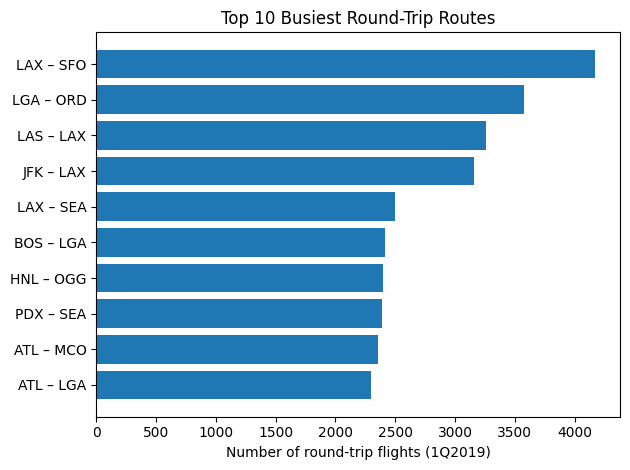

In [6]:
# Chart 1: Top 10 busiest round-trip routes

import matplotlib.pyplot as plt

top10_busiest_sorted = (
    top10_busiest
    .sort_values("roundtrip_flights", ascending=True)
)

labels = top10_busiest_sorted["AIRPORT_A"] + " – " + top10_busiest_sorted["AIRPORT_B"]

plt.figure()
plt.barh(labels, top10_busiest_sorted["roundtrip_flights"])
plt.xlabel("Number of round-trip flights (1Q2019)")
plt.title("Top 10 Busiest Round-Trip Routes")
plt.tight_layout()
plt.show()


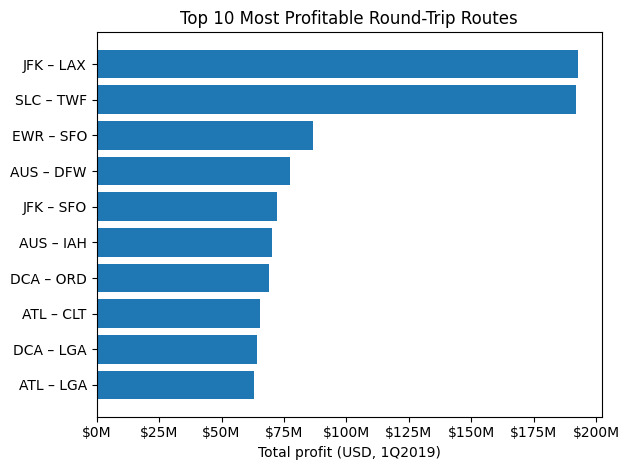

In [7]:
# Chart 2: Top 10 most profitable round-trip routes

import matplotlib.pyplot as plt

top10_profit_sorted = (
    top10_profit
    .sort_values("profit", ascending=True)
)

labels = top10_profit_sorted["AIRPORT_A"] + " – " + top10_profit_sorted["AIRPORT_B"]

plt.figure()
plt.barh(labels, top10_profit_sorted["profit"])
plt.xlabel("Total profit (USD, 1Q2019)")
plt.title("Top 10 Most Profitable Round-Trip Routes")

import matplotlib.ticker as mtick

ax = plt.gca()
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M")
)

plt.tight_layout()
plt.show()


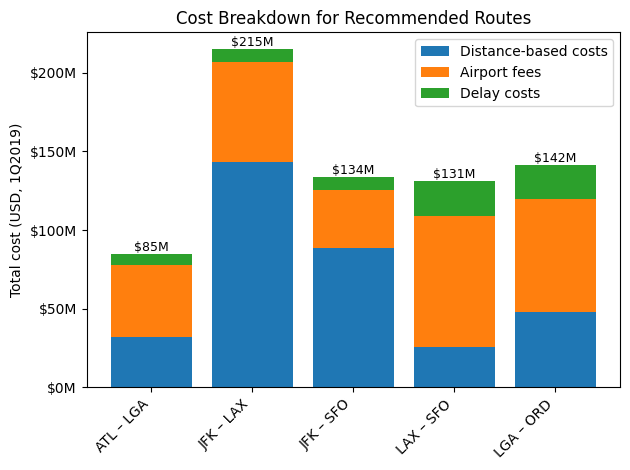

In [8]:
# Chart 3: Cost breakdown for recommended routes

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

recommended = route_costs.loc[
    route_costs.set_index(["AIRPORT_A", "AIRPORT_B"]).index.isin(
        [
            ("JFK", "LAX"),
            ("JFK", "SFO"),
            ("LAX", "SFO"),
            ("LGA", "ORD"),
            ("ATL", "LGA"),
        ]
    )
].copy()

labels = recommended["AIRPORT_A"] + " – " + recommended["AIRPORT_B"]

plt.figure()
plt.bar(
    labels,
    recommended["total_distance_cost"],
    label="Distance-based costs",
)
plt.bar(
    labels,
    recommended["total_airport_fees"],
    bottom=recommended["total_distance_cost"],
    label="Airport fees",
)
plt.bar(
    labels,
    recommended["total_delay_cost"],
    bottom=(
        recommended["total_distance_cost"]
        + recommended["total_airport_fees"]
    ),
    label="Delay costs",
)

plt.ylabel("Total cost (USD, 1Q2019)")
plt.title("Cost Breakdown for Recommended Routes")
plt.xticks(rotation=45, ha="right")
plt.legend()

# === format y-axis as $M ===
ax = plt.gca()
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M")
)

# === add total cost labels at top of each bar ===
totals = (
    recommended["total_distance_cost"]
    + recommended["total_airport_fees"]
    + recommended["total_delay_cost"]
)

for i, total in enumerate(totals):
    ax.text(
        i,
        total,
        f"${total/1e6:.0f}M",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


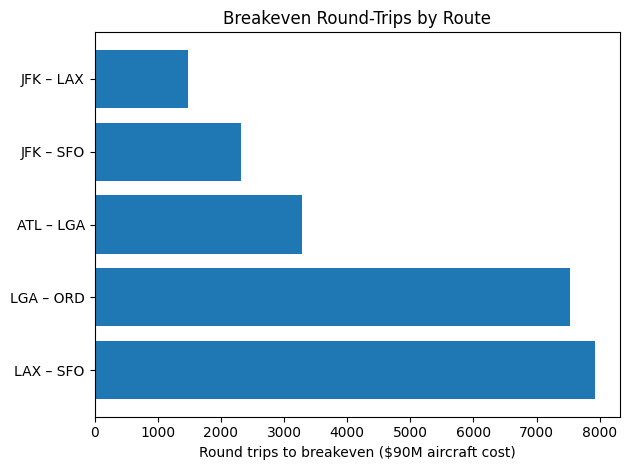

In [9]:
# Chart 4: Breakeven round-trip comparison

import matplotlib.pyplot as plt

breakeven_sorted = breakeven.sort_values("breakeven_roundtrips", ascending=False)

labels = breakeven_sorted["AIRPORT_A"] + " – " + breakeven_sorted["AIRPORT_B"]

plt.figure()
plt.barh(labels, breakeven_sorted["breakeven_roundtrips"])
plt.xlabel("Round trips to breakeven ($90M aircraft cost)")
plt.title("Breakeven Round-Trips by Route")
plt.tight_layout()
plt.show()


Breakeven analysis includes the $90M upfront aircraft cost per route.

In [ ]:
# === Export tables for review ===
# === Export note ===
# Tables used in the analysis have been saved to the outputs/ directory
# for review and reuse. These files are regenerated when the export cells are run.


top10_busiest.to_csv(
    "outputs/tables/top10_busiest_routes.csv",
    index=False
)

top10_profit.to_csv(
    "outputs/tables/top10_profitable_routes.csv",
    index=False
)

decision_view.to_csv(
    "outputs/tables/decision_comparison_view.csv",
    index=False
)

breakeven.sort_values("breakeven_roundtrips").to_csv(
    "outputs/tables/breakeven_analysis.csv",
    index=False
)

print("Tables exported to outputs/tables/")
